In [1]:
git_repo = '../../..'

import sys
import os

sys.path.insert(0, os.path.join(git_repo, 'BNP_sensitivity/GMM_clustering/'))

# Linear response libraries
import LinearResponseVariationalBayes as vb
import LinearResponseVariationalBayes.SparseObjectives as obj_lib

# Local libraries
import gmm_clustering_lib as gmm_utils
import modeling_lib 
import functional_sensitivity_lib as fun_sens_lib 
import utils_lib

import matplotlib.pyplot as plt
%matplotlib inline

from copy import deepcopy

import numpy as np
import scipy as sp

np.random.seed(453453)

import json 

In [2]:
# Load results from previous fit.
json_input_file = os.path.join(
    git_repo, 'BNP_sensitivity/GMM_clustering/iris_fits/ryan_iris_bnp_full_data_fit.json')

with open(json_input_file, 'r') as fp:
    fit_dict = json.load(fp)
    model = gmm_utils.get_model_from_checkpoint(fit_dict)
    model_ = gmm_utils.get_model_from_checkpoint(fit_dict)
    best_param = model.global_vb_params.get_free()
    kl_hessian = gmm_utils.get_kl_hessian_from_checkpoint(fit_dict)

In [3]:
moment_model = gmm_utils.InterestingMoments(model)
dg_deta = moment_model.get_moment_jacobian(best_param)
linear_sens = gmm_utils.LinearSensitivity(model, moment_model, kl_hessian)

Prior Hessian...
Data Hessian...
Linear systems...
Done.


In [4]:
model_refit = deepcopy(model)
print(model.prior_params)

prior_params:
	alpha: [8.]
	prior_centroid_mean: [0.]
	prior_centroid_info: [0.1]
	prior_gamma_df: [8.]
	prior_gamma_inv_scale:
[[0.62 0.   0.   0.  ]
 [0.   0.62 0.   0.  ]
 [0.   0.   0.62 0.  ]
 [0.   0.   0.   0.62]]


In [5]:
def refit_with_alpha(new_alpha, model, linear_sens):
    model_refit = deepcopy(model)
    model_refit.prior_params['alpha'].set(new_alpha)
    free_par_refit = linear_sens.predict_from_prior_params(
        model_refit.prior_params.get_free())
    model_refit.optimize_full(free_par_refit,
        init_max_iter=100,
        final_max_iter=500)
    return free_par_refit, model_refit.global_vb_params.get_free()


In [ ]:
alpha_vec = np.linspace(1, 7, num=7)
print(alpha_vec)
free_par_refit_list = []
free_par_refit_lr_list = []
for alpha in alpha_vec:
    print('\n\nalpha: ', alpha)
    free_par_refit, free_par_refit_lr = refit_with_alpha(7.0, model, linear_sens)
    free_par_refit_list.append(free_par_refit)
    free_par_refit_lr_list.append(free_par_refit_lr)
        

[1. 2. 3. 4. 5. 6. 7.]
alpha:  1.0
BGFS
Iter: 0	 RMSE: 11.273748064624897	 Objective: -307.08800593595265
Iter: 10	 RMSE: 11.27341170499429	 Objective: -307.08802435798697
Iter: 20	 RMSE: 11.27348956362151	 Objective: -307.0880277717437
Iter: 30	 RMSE: 11.273489565194856	 Objective: -307.0880277717453
Iter: 40	 RMSE: 11.273489565195295	 Objective: -307.0880277717463
Iter: 50	 RMSE: 11.273489565195295	 Objective: -307.0880277717463
Iter: 60	 RMSE: 11.27352718598674	 Objective: -307.08802701318314
Iter: 70	 RMSE: 11.273476173711932	 Objective: -307.08802766306934
         Current function value: -307.088017
         Iterations: 1
         Function evaluations: 73
         Gradient evaluations: 62
Conditioned Newton:
i =  0
Iter: 80	 RMSE: 11.273618903061408	 Objective: -307.08802036663417
Iter: 90	 RMSE: 11.273629513567565	 Objective: -307.08801700868327
Iter: 100	 RMSE: 11.273629513576992	 Objective: -307.08801700868173
         Current function value: -307.088017
         Iterations: 2

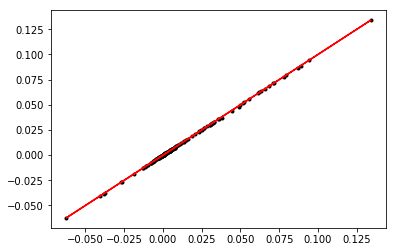

In [9]:
plt.plot(free_par_refit - best_param, free_par_refit_lr - best_param, 'k.')
plt.plot(free_par_refit - best_param, free_par_refit - best_param, 'r')